## Example: Fitting a Gaussian signal with Linear Regression

Let us now take a step forward in our experiment: we want to fit the full curve.

As seen on the blackboard, we can devise a family of basis functions 

$$ 
y(\underline x, \underline \omega) = \omega_0 + \sum_{j=1}^{M-1} \omega_j \phi_j(\underline x) = \underline \omega^T \underline \phi (\underline x)
$$

to model complicated signals, and as long as the model is linear in the parameters $\underline\omega$, we can use the generalized least squared method.


Remember: the raw signal is composed by a Gaussian curve + a linear background + random Gaussian noise, so

$$
y^i(\underline x, \underline \omega) = = \omega_0 + \omega_1 x^i + \frac{1}{\sqrt{2\pi}\omega_2} e^{-\frac{(x^i - \omega_3)^2}{2\omega_2^2}}
$$

We immediately notice that the model we want to build is non-linear in the parameters, because of the Gaussian. 

We will talk about non-linear regression in the next lecture, but for now let us work with what we have.

In the specific case of the Gaussian, there is a simple way to linearize the problem, which is considering the log of the Gaussian part, transforming it into a polynomial form.

`GOAL: Find a model for the raw signal and use it to measure the position and width of signal from the experimental setup.`

### Generate Synthetic Experiment

As seen before, it is good practice to take the experiment multiple times to average noise out. 

We assume again that the signal and background are very stable in time.

In [1]:
import sys
sys.path.append('../../../supplemental_material')

import numpy as np
import matplotlib.pyplot as plt
import synth_dataset as sd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
takes = 20
# array of x values
x = np.linspace(0,1,100)
# produce a single gaussian peak signal
signal = sd.random_peaks(x,peaks_range=[1,2],c = 0.10, roi_position=[0.45,0.55],ph_min = 0.1, ph_max = 0.5, edge_tol=0.2,method=2)
# produce a linear background 
background = sd.linear_bg(len(x))
# add random noise to generate the raw signal
raw = [sd.add_noise(snr=20, signal = signal + background) for i in range(takes)]
mean_raw = np.mean(raw,axis=0)

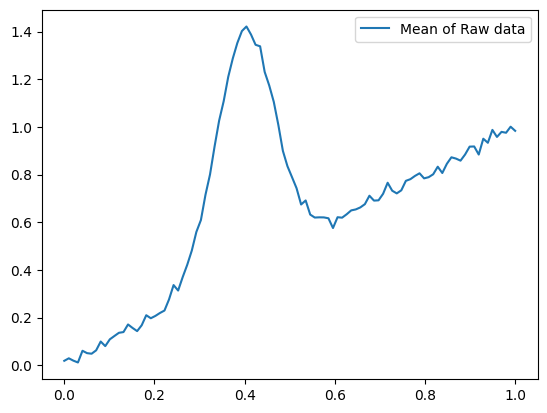

In [3]:
# plot the data
plt.plot(x,mean_raw,label='Mean of Raw data')
plt.legend()
plt.show()

### Modelling the Background

Let us assume we are able to remove the background as before.

In [4]:
beta = np.sum((x-np.mean(x))*(background - np.mean(background)))/np.sum((x-np.mean(x))**2)
alpha = np.mean(background) - np.mean(x)*beta

We can now subtract it from the mean of the 20 takes

In [5]:
signal = raw - (alpha + beta*x)
mean_signal = np.mean(signal,axis=0)

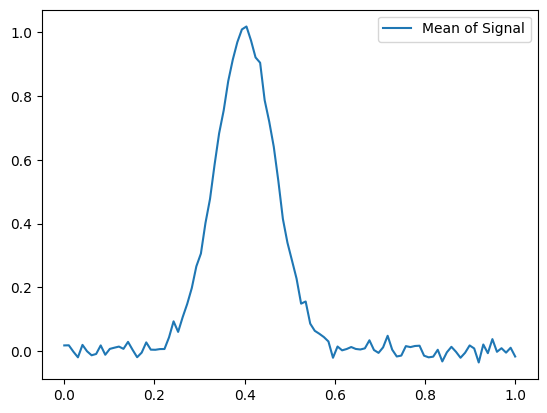

In [6]:
# plot the data
plt.plot(x,mean_signal,label='Mean of Signal')
plt.legend()
plt.show()

### Modelling the signal

We linearize the Gaussian part of the raw data by taking the log of the Gaussian signal

$$
y^i_{\rm log} = \omega_{\log,0} + \omega_{\log,1} x^i + \omega_{\log,2} (x^i)^{2}
$$

where the position of the peak is given by $\mu = - \frac{\omega_{\log,1}}{2\,\omega_{\log,2}}$ and the variance $\sigma^2 = -\frac{1}{2\, \omega_{\log,2}}$

Note that taking the log of the signal is not a well defined operation, since it is not positive definite. However, we can work with the mean of the takes on the domain where the Gaussian is much greater than the noise.

In [7]:
log_signal = np.log(signal)

log_signal = np.nan_to_num(log_signal, nan=-np.inf)

mean_log_signal = np.mean(log_signal,axis=0)

/var/folders/tw/pcfht9hj7db0kf8wlp56b2v40000gn/T/ipykernel_72975/4207216857.py:1: RuntimeWarning: invalid value encountered in log
  log_signal = np.log(signal)


In [8]:
ind = np.where(mean_log_signal != -np.inf)

In [9]:
x_log = x[ind]
mean_log_signal = mean_log_signal[ind]

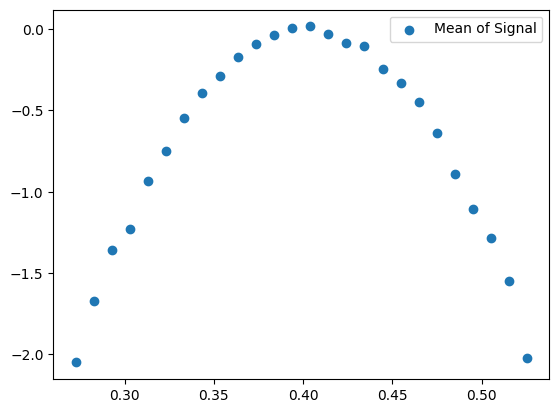

In [10]:
plt.scatter(x_log,mean_log_signal,label='Mean of Signal')
plt.legend()
plt.show()

As an exercise, we can write this model in terms of basis functions 

In [11]:
phi = np.zeros((3,len(x_log)))
for i in range(3):
    phi[i] = x_log**i

In [12]:
weights = np.linalg.inv(phi@phi.T)@phi@mean_log_signal

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [13]:
prediction = weights@phi

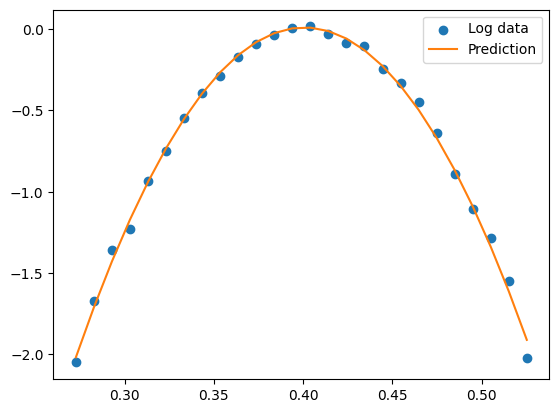

In [14]:
plt.scatter(x_log,mean_log_signal,label='Log data')
plt.plot(x_log,prediction,label='Prediction', c='C1')
plt.legend()
plt.show()

Now we convert weights back to exponential form

In [15]:
model = np.exp(weights[0] + weights[1]*x + weights[2]*x**2)

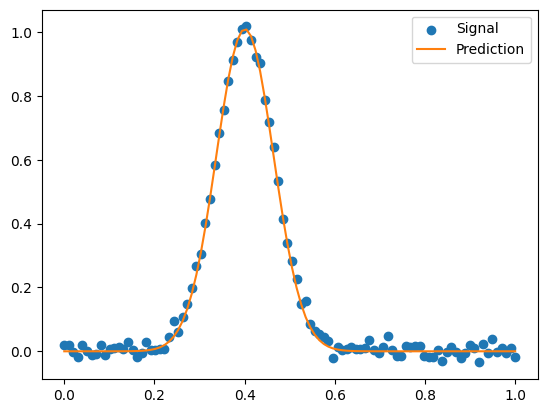

In [16]:
plt.scatter(x,mean_signal,label='Signal')
plt.plot(x,model,label='Prediction', c='C1')
plt.legend()
plt.show()

We can now get the value of the mean and width of the peak:

In [17]:
mu = -weights[1]/(2*weights[2])
sigma = np.sqrt(-1/(2*weights[2]))

print('The mean of the gaussian is:', mu)
print('The standard deviation of the gaussian is:', sigma)

The mean of the gaussian is: 0.40070102529757584
The standard deviation of the gaussian is: 0.06355916141286637


### Exercise 1: calculating error on weights

`Remark: several takes of the same experiment are useful to get an estimate of the error on the parameters. In this context though we had to linearize a noisy Gaussian, thus we were forced to work with the mean. `

We can still exploit different takes with a few tricks. Let us suppose we increase greatly the number of takes

In [18]:
log_signal = np.log(signal)

log_signal = np.nan_to_num(log_signal, nan=-np.inf)

mean_log_signal = np.mean(log_signal,axis=0)


/var/folders/tw/pcfht9hj7db0kf8wlp56b2v40000gn/T/ipykernel_72975/3660731934.py:1: RuntimeWarning: invalid value encountered in log
  log_signal = np.log(signal)


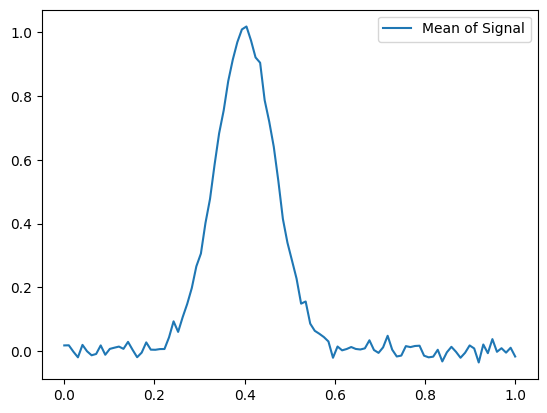

In [19]:
# plot the data
plt.plot(x,mean_signal,label='Mean of Signal')
plt.legend()
plt.show()

We can define a threshold for which the peak is much higher than the noise and select only log signal above that threshold

In [20]:
threshold = 0.1

In [21]:
ind_log = []
for i in range(takes):
    ind_log.append(np.where(log_signal[i] > np.log10(threshold))[0])

In [22]:
x_log = []
log_signal_ind = []
for i in range(takes):
    x_log.append(x[ind_log[i]])
    log_signal_ind.append(log_signal[i][ind_log[i]])


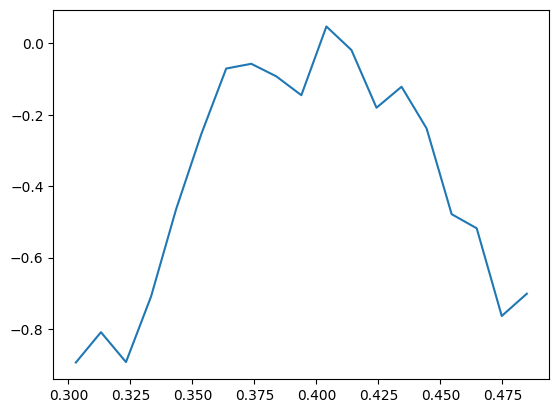

In [23]:
plt.plot(x_log[1],log_signal_ind[1],label='Log data')

Now we are forced to define basis functions for each take, since they have different x values because of the selection

In [24]:
phi_ind_temp = np.zeros((takes,3,len(x)))
for i in range(takes):
    for j in range(3):
        phi_ind_temp[i,j] = x**j

In [25]:
phi_ind = []
for i in range(takes):
    phi_ind.append(phi_ind_temp[i][:,ind_log[i]])

We compute the weights for each take

In [26]:
weights_ind = [np.linalg.inv(phi_ind[i]@phi_ind[i].T)@phi_ind[i]@log_signal_ind[i] for i in range(takes)]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


And we then combine them together, calculating an error on them based on the takes.

In [27]:
model_ind_i = np.zeros((takes,len(x)))
for i in range(takes):
    model_ind_i[i] = np.exp(weights_ind[i][0] + weights_ind[i][1]*x + weights_ind[i][2]*x**2)

model_ind_mean = np.mean(model_ind_i,axis=0)
model_ind_std = np.std(model_ind_i,axis=0,ddof=1)

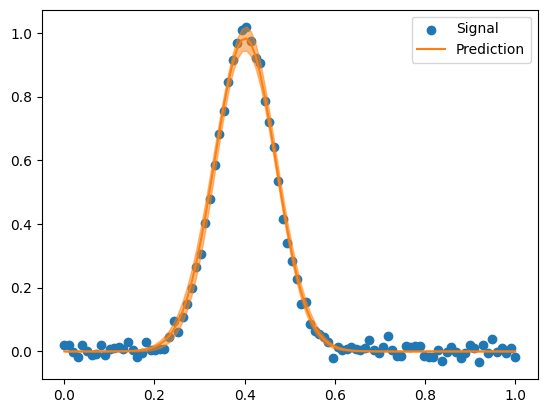

In [28]:
plt.scatter(x,mean_signal,label='Signal')
plt.plot(x,model_ind_mean,label='Prediction', c='C1')
plt.fill_between(x, model_ind_mean-model_ind_std,model_ind_mean+model_ind_std, color='C1',alpha=0.5)
#plt.ylim(-2,2)
plt.legend()
plt.show()

And a zoom in on the peak

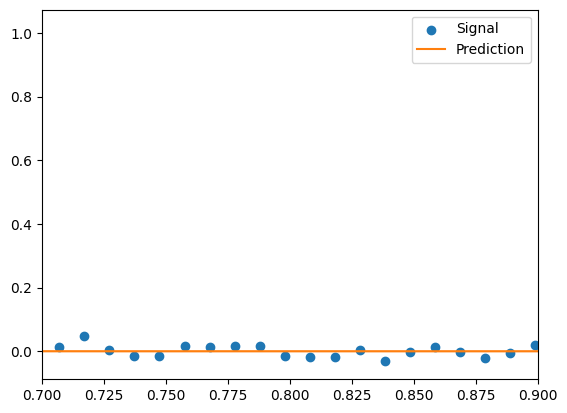

In [29]:
plt.scatter(x,mean_signal,label='Signal')
plt.plot(x,model_ind_mean,label='Prediction', c='C1')
plt.fill_between(x, model_ind_mean-model_ind_std,model_ind_mean+model_ind_std, color='C1',alpha=0.5)
plt.xlim(0.7,0.9)
plt.legend()
plt.show()

We can now estimate again the mean and width of the peak, which now come with an error bar

In [30]:
mu_ind = np.mean([-weights_ind[i][1]/(2*weights_ind[i][2]) for i in range(takes)])
err_mu_ind = np.std([-weights_ind[i][1]/(2*weights_ind[i][2]) for i in range(takes)],ddof=1)
sigma_ind = np.mean([np.sqrt(-1/(2*weights_ind[i][2])) for i in range(takes)])
err_sigma_ind = np.std([np.sqrt(-1/(2*weights_ind[i][2])) for i in range(takes)],ddof=1)

print('The mean of the gaussian is: %.4f +- %.4f' %(mu_ind,err_mu_ind))
print('The standard deviation of the gaussian is: %.4f +- %.4f' %(sigma,err_sigma_ind))

The mean of the gaussian is: 0.4009 +- 0.0033
The standard deviation of the gaussian is: 0.0636 +- 0.0035
